Tutorial from: https://medium.com/dataseries/convolutional-autoencoder-in-pytorch-on-mnist-dataset-d65145c132ac

In [28]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from typing import Any, Callable, Dict, List, Optional, Tuple
import MyMnistDataset

class MyDataLoader(torchvision.datasets.MNIST):


    def __getitem__(self, index: int) -> Tuple[Any, Any]:
        """
        Args:x
            index (int): Index

        Returns:
            tuple: (image, target) where target is index of the target class.
        """
        resize_transform = transforms.Compose([
            transforms.Resize((20, 20))
        ])
        img, _ = self.data[index], int(self.targets[index])

        # doing this so that it is consistent with all other datasets
        # to return a PIL Image
        img = Image.fromarray(img.numpy(), mode="L")
        small_img = resize_transform(img)

        if self.transform is not None:
            img = self.transform(img)
            small_img = self.transform(small_img)

        return img, small_img

data_dir = 'mydataset'

train_dataset = MyDataLoader(data_dir, train=True, download=True)
test_dataset  = MyDataLoader(data_dir, train=False, download=True)

train_transform = transforms.Compose([
transforms.ToTensor(),
])

test_transform = transforms.Compose([
transforms.ToTensor(),
])

train_dataset.transform = train_transform
test_dataset.transform = test_transform

m=len(train_dataset)

train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])
batch_size=256

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [29]:
class SmallEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(2 * 2 * 32, 64),
            nn.ReLU(True),
            nn.Linear(64, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class BigEncoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x

class SmallDecoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 64),
            nn.ReLU(True),
            nn.Linear(64, 2 * 2 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 2, 2))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

class BigDecoder(nn.Module):
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1,
                                      unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3,
                               stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2,
                               padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2,
                               padding=1, output_padding=1)
        )

    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [30]:

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 32

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = SmallEncoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = BigDecoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder = encoder.to(device)
decoder = decoder.to(device)

Selected device: cuda


In [31]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, small_image_batch in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        small_image_batch = small_image_batch.to(device)
        # Encode data
        encoded_data = encoder(small_image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch.to(device))
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [32]:

### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, small_image_batch in dataloader:
            # Move tensor to the proper device
            small_image_batch = small_image_batch.to(device)
            # Encode data
            encoded_data = encoder(small_image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [33]:

def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    targets = test_dataset.targets.numpy()
    t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      size_index = 0 #  for 28x28
      size_index = 1 #  for 20x20
      img = test_dataset[t_idx[i]][size_index].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(test_dataset[t_idx[i]][0].unsqueeze(1).to(device).cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [34]:
# diz_loss = {'train_loss':[],'val_loss':[]}

	 partial train loss (single batch): 0.245420
	 partial train loss (single batch): 0.239364
	 partial train loss (single batch): 0.235773
	 partial train loss (single batch): 0.231776
	 partial train loss (single batch): 0.228619
	 partial train loss (single batch): 0.225737
	 partial train loss (single batch): 0.223927
	 partial train loss (single batch): 0.220993
	 partial train loss (single batch): 0.219318
	 partial train loss (single batch): 0.217215
	 partial train loss (single batch): 0.215515
	 partial train loss (single batch): 0.213800
	 partial train loss (single batch): 0.212017
	 partial train loss (single batch): 0.210070
	 partial train loss (single batch): 0.208515
	 partial train loss (single batch): 0.206960
	 partial train loss (single batch): 0.204845
	 partial train loss (single batch): 0.202987
	 partial train loss (single batch): 0.201498
	 partial train loss (single batch): 0.200080
	 partial train loss (single batch): 0.198417
	 partial train loss (single batch

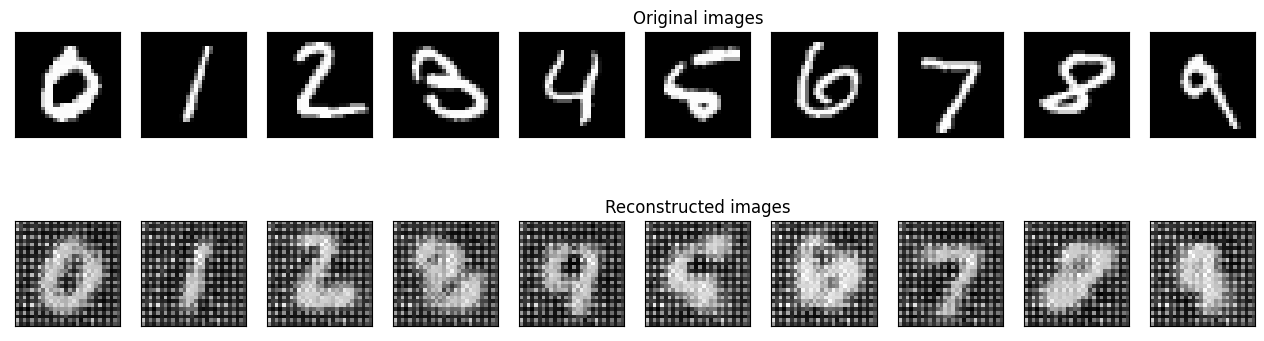

	 partial train loss (single batch): 0.076901
	 partial train loss (single batch): 0.078149
	 partial train loss (single batch): 0.076599
	 partial train loss (single batch): 0.077466
	 partial train loss (single batch): 0.076660
	 partial train loss (single batch): 0.076525
	 partial train loss (single batch): 0.075326
	 partial train loss (single batch): 0.075600
	 partial train loss (single batch): 0.075529
	 partial train loss (single batch): 0.075013
	 partial train loss (single batch): 0.075142
	 partial train loss (single batch): 0.073860
	 partial train loss (single batch): 0.073656
	 partial train loss (single batch): 0.073246
	 partial train loss (single batch): 0.072719
	 partial train loss (single batch): 0.073686
	 partial train loss (single batch): 0.072989
	 partial train loss (single batch): 0.072318
	 partial train loss (single batch): 0.073288
	 partial train loss (single batch): 0.071715
	 partial train loss (single batch): 0.071236
	 partial train loss (single batch

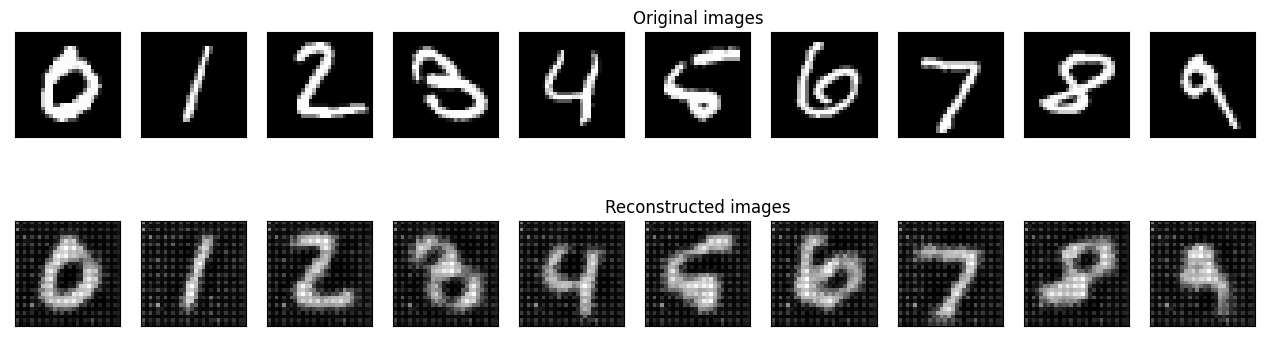

	 partial train loss (single batch): 0.034463
	 partial train loss (single batch): 0.035303
	 partial train loss (single batch): 0.033819
	 partial train loss (single batch): 0.034761
	 partial train loss (single batch): 0.034208
	 partial train loss (single batch): 0.034571
	 partial train loss (single batch): 0.033387
	 partial train loss (single batch): 0.033975
	 partial train loss (single batch): 0.033701
	 partial train loss (single batch): 0.033601
	 partial train loss (single batch): 0.034075
	 partial train loss (single batch): 0.032973
	 partial train loss (single batch): 0.032544
	 partial train loss (single batch): 0.032963
	 partial train loss (single batch): 0.032559
	 partial train loss (single batch): 0.033257
	 partial train loss (single batch): 0.033104
	 partial train loss (single batch): 0.032931
	 partial train loss (single batch): 0.033289
	 partial train loss (single batch): 0.032139
	 partial train loss (single batch): 0.032120
	 partial train loss (single batch

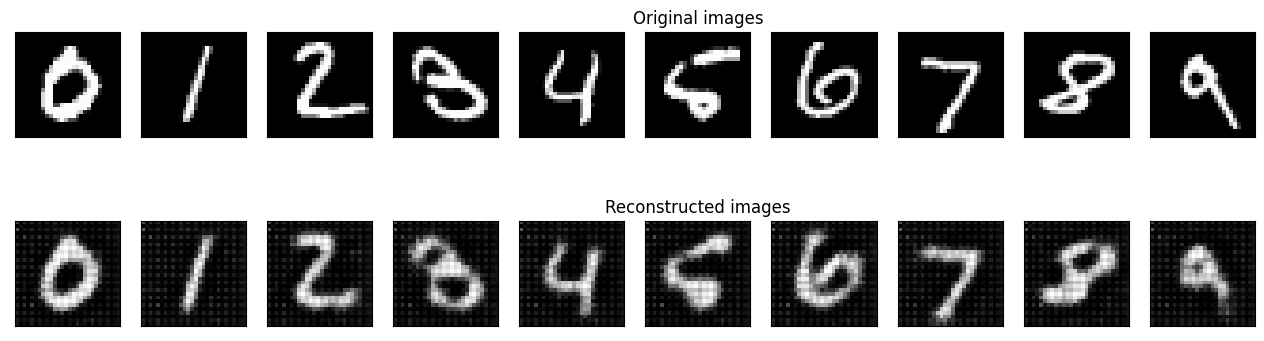

	 partial train loss (single batch): 0.020753
	 partial train loss (single batch): 0.021197
	 partial train loss (single batch): 0.020409
	 partial train loss (single batch): 0.021168
	 partial train loss (single batch): 0.020346
	 partial train loss (single batch): 0.020977
	 partial train loss (single batch): 0.020388
	 partial train loss (single batch): 0.020476
	 partial train loss (single batch): 0.020109
	 partial train loss (single batch): 0.020362
	 partial train loss (single batch): 0.020860
	 partial train loss (single batch): 0.020021
	 partial train loss (single batch): 0.019555
	 partial train loss (single batch): 0.019987
	 partial train loss (single batch): 0.019978
	 partial train loss (single batch): 0.020305
	 partial train loss (single batch): 0.020531
	 partial train loss (single batch): 0.020427
	 partial train loss (single batch): 0.020613
	 partial train loss (single batch): 0.020320
	 partial train loss (single batch): 0.019745
	 partial train loss (single batch

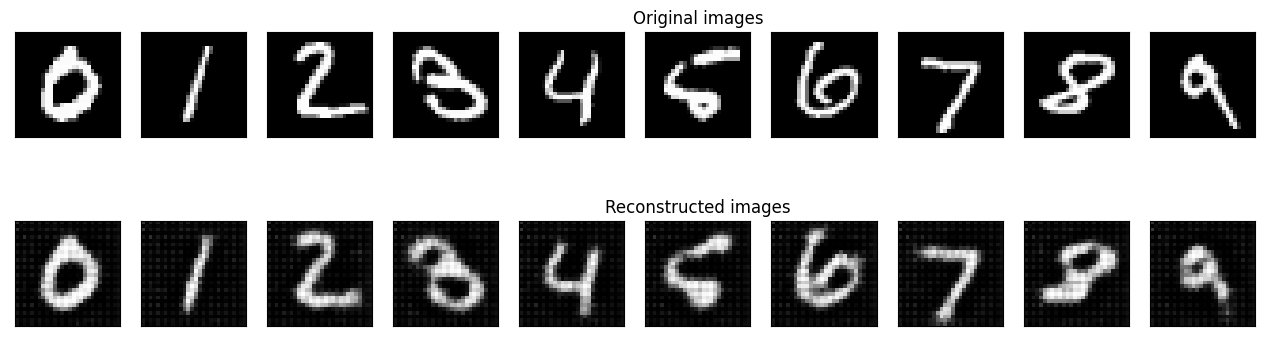

	 partial train loss (single batch): 0.015947
	 partial train loss (single batch): 0.016151
	 partial train loss (single batch): 0.015425
	 partial train loss (single batch): 0.016132
	 partial train loss (single batch): 0.015374
	 partial train loss (single batch): 0.016153
	 partial train loss (single batch): 0.015650
	 partial train loss (single batch): 0.015540
	 partial train loss (single batch): 0.015483
	 partial train loss (single batch): 0.015323
	 partial train loss (single batch): 0.016076
	 partial train loss (single batch): 0.015482
	 partial train loss (single batch): 0.015020
	 partial train loss (single batch): 0.015263
	 partial train loss (single batch): 0.015354
	 partial train loss (single batch): 0.015376
	 partial train loss (single batch): 0.016281
	 partial train loss (single batch): 0.015713
	 partial train loss (single batch): 0.015808
	 partial train loss (single batch): 0.015305
	 partial train loss (single batch): 0.015040
	 partial train loss (single batch

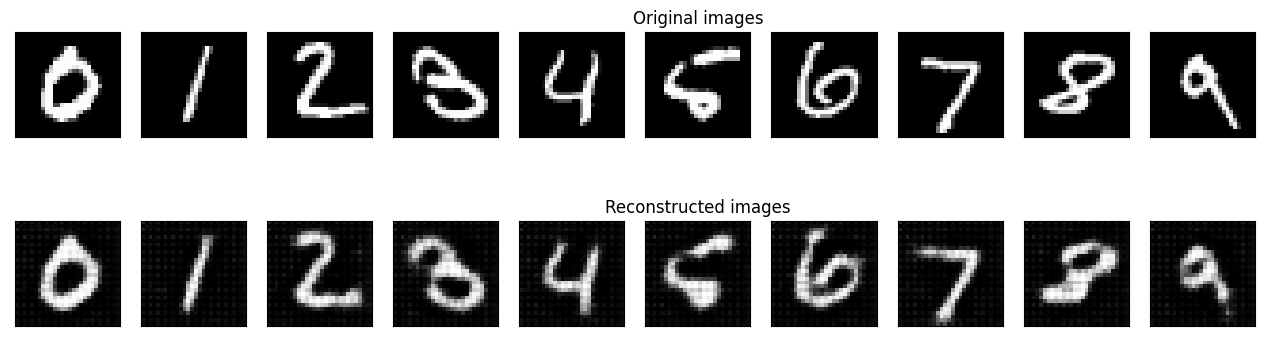

	 partial train loss (single batch): 0.013627
	 partial train loss (single batch): 0.013984
	 partial train loss (single batch): 0.012964
	 partial train loss (single batch): 0.013981
	 partial train loss (single batch): 0.012832
	 partial train loss (single batch): 0.013873
	 partial train loss (single batch): 0.013348
	 partial train loss (single batch): 0.013395
	 partial train loss (single batch): 0.013218
	 partial train loss (single batch): 0.013162
	 partial train loss (single batch): 0.013701
	 partial train loss (single batch): 0.013118
	 partial train loss (single batch): 0.012622
	 partial train loss (single batch): 0.012906
	 partial train loss (single batch): 0.012884
	 partial train loss (single batch): 0.013202
	 partial train loss (single batch): 0.013547
	 partial train loss (single batch): 0.013292
	 partial train loss (single batch): 0.013389
	 partial train loss (single batch): 0.012828
	 partial train loss (single batch): 0.012632
	 partial train loss (single batch

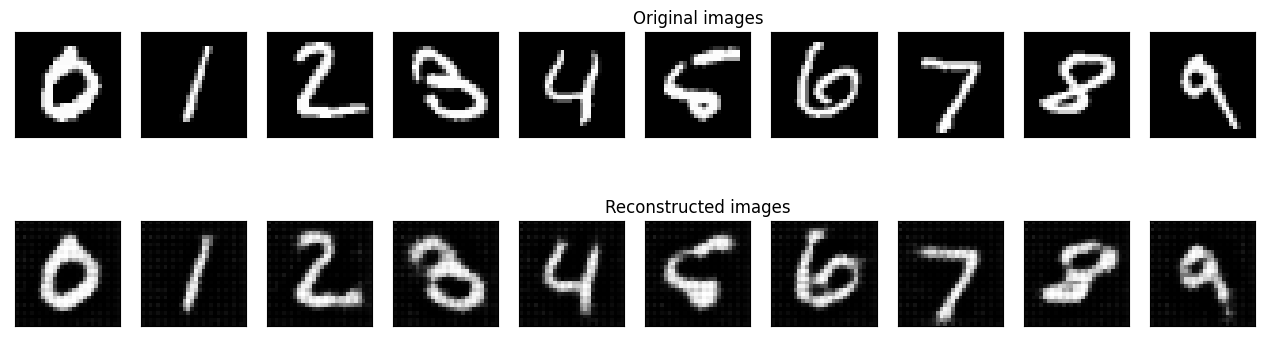

	 partial train loss (single batch): 0.012022
	 partial train loss (single batch): 0.012278
	 partial train loss (single batch): 0.011422
	 partial train loss (single batch): 0.012177
	 partial train loss (single batch): 0.011420
	 partial train loss (single batch): 0.012133
	 partial train loss (single batch): 0.011833
	 partial train loss (single batch): 0.011860
	 partial train loss (single batch): 0.011549
	 partial train loss (single batch): 0.011595
	 partial train loss (single batch): 0.012186
	 partial train loss (single batch): 0.011659
	 partial train loss (single batch): 0.011225
	 partial train loss (single batch): 0.011564
	 partial train loss (single batch): 0.011467
	 partial train loss (single batch): 0.011782
	 partial train loss (single batch): 0.012076
	 partial train loss (single batch): 0.011741
	 partial train loss (single batch): 0.011845
	 partial train loss (single batch): 0.011283
	 partial train loss (single batch): 0.011328
	 partial train loss (single batch

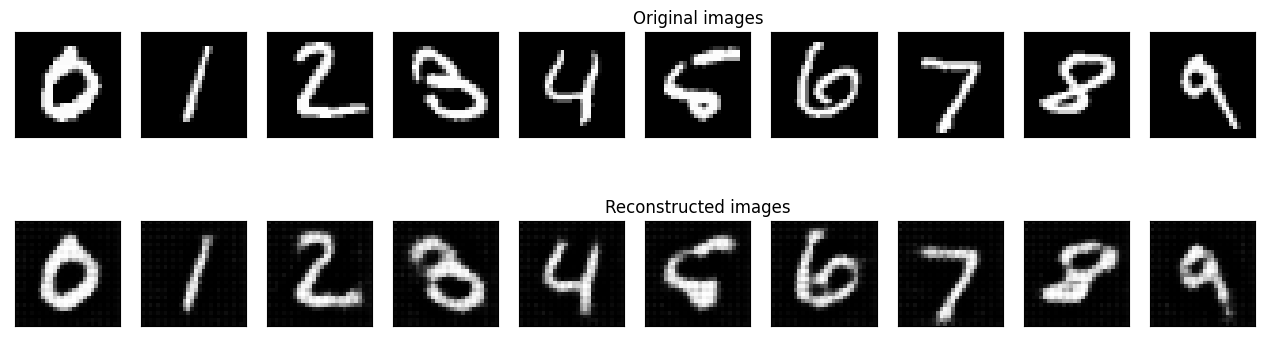

	 partial train loss (single batch): 0.011134
	 partial train loss (single batch): 0.011197
	 partial train loss (single batch): 0.010532
	 partial train loss (single batch): 0.011227
	 partial train loss (single batch): 0.010457
	 partial train loss (single batch): 0.011170
	 partial train loss (single batch): 0.010862
	 partial train loss (single batch): 0.010899
	 partial train loss (single batch): 0.010628
	 partial train loss (single batch): 0.010750
	 partial train loss (single batch): 0.011189
	 partial train loss (single batch): 0.010726
	 partial train loss (single batch): 0.010283
	 partial train loss (single batch): 0.010665
	 partial train loss (single batch): 0.010467
	 partial train loss (single batch): 0.010845
	 partial train loss (single batch): 0.011093
	 partial train loss (single batch): 0.010837
	 partial train loss (single batch): 0.010968
	 partial train loss (single batch): 0.010334
	 partial train loss (single batch): 0.010449
	 partial train loss (single batch

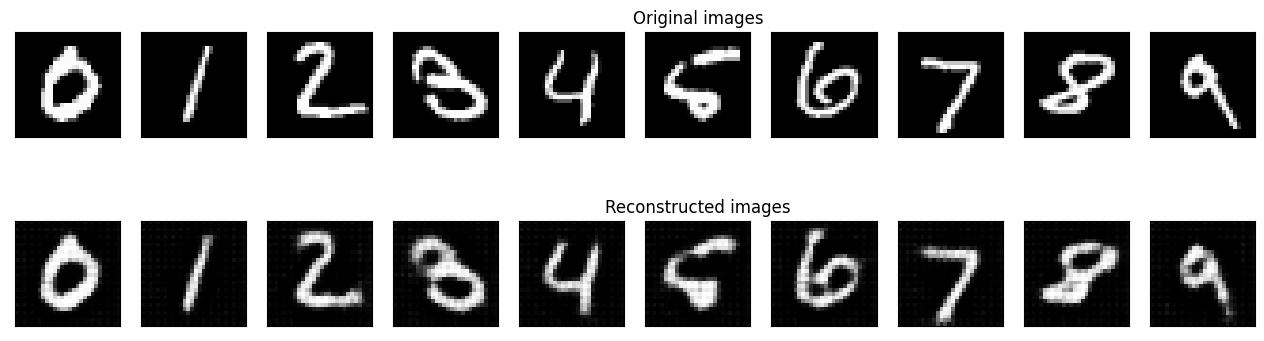

	 partial train loss (single batch): 0.010554
	 partial train loss (single batch): 0.010610
	 partial train loss (single batch): 0.009898
	 partial train loss (single batch): 0.010655
	 partial train loss (single batch): 0.009833
	 partial train loss (single batch): 0.010624
	 partial train loss (single batch): 0.010070
	 partial train loss (single batch): 0.010311
	 partial train loss (single batch): 0.009980
	 partial train loss (single batch): 0.010178
	 partial train loss (single batch): 0.010495
	 partial train loss (single batch): 0.010029
	 partial train loss (single batch): 0.009701
	 partial train loss (single batch): 0.009819
	 partial train loss (single batch): 0.009795
	 partial train loss (single batch): 0.010088
	 partial train loss (single batch): 0.010387
	 partial train loss (single batch): 0.010179
	 partial train loss (single batch): 0.010281
	 partial train loss (single batch): 0.009639
	 partial train loss (single batch): 0.009865
	 partial train loss (single batch

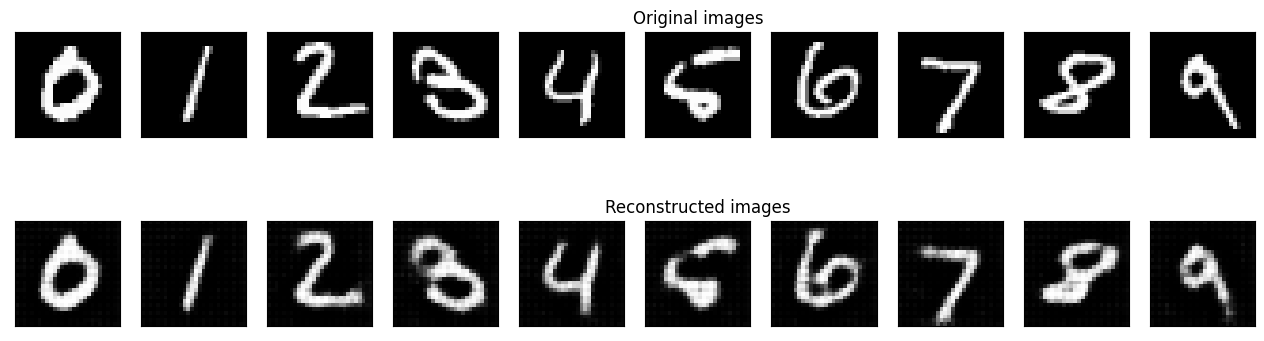

	 partial train loss (single batch): 0.010150
	 partial train loss (single batch): 0.009917
	 partial train loss (single batch): 0.009466
	 partial train loss (single batch): 0.010047
	 partial train loss (single batch): 0.009249
	 partial train loss (single batch): 0.010013
	 partial train loss (single batch): 0.009504
	 partial train loss (single batch): 0.009772
	 partial train loss (single batch): 0.009288
	 partial train loss (single batch): 0.009689
	 partial train loss (single batch): 0.009816
	 partial train loss (single batch): 0.009589
	 partial train loss (single batch): 0.009028
	 partial train loss (single batch): 0.009293
	 partial train loss (single batch): 0.009264
	 partial train loss (single batch): 0.009626
	 partial train loss (single batch): 0.009834
	 partial train loss (single batch): 0.009751
	 partial train loss (single batch): 0.009746
	 partial train loss (single batch): 0.009233
	 partial train loss (single batch): 0.009304
	 partial train loss (single batch

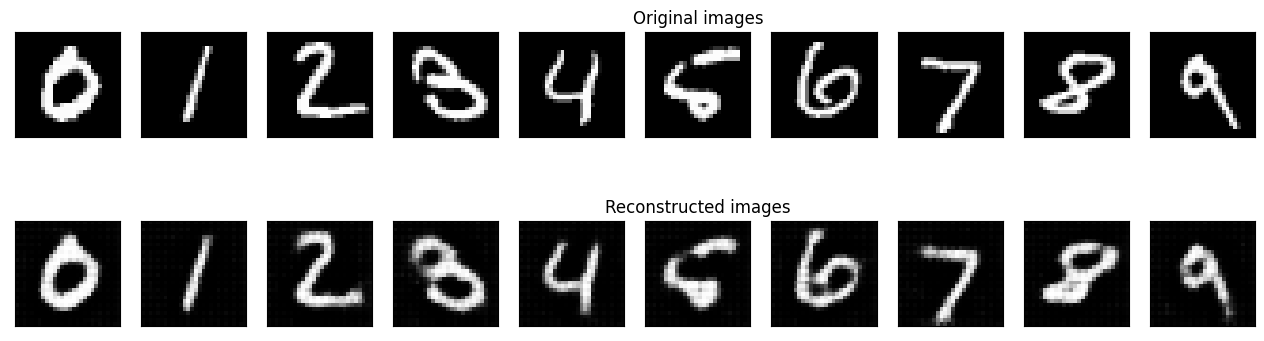

	 partial train loss (single batch): 0.009616
	 partial train loss (single batch): 0.009496
	 partial train loss (single batch): 0.009099
	 partial train loss (single batch): 0.009499
	 partial train loss (single batch): 0.008941
	 partial train loss (single batch): 0.009488
	 partial train loss (single batch): 0.009180
	 partial train loss (single batch): 0.009277
	 partial train loss (single batch): 0.008932
	 partial train loss (single batch): 0.009197
	 partial train loss (single batch): 0.009461
	 partial train loss (single batch): 0.009001
	 partial train loss (single batch): 0.008726
	 partial train loss (single batch): 0.008806
	 partial train loss (single batch): 0.008826
	 partial train loss (single batch): 0.009137
	 partial train loss (single batch): 0.009483
	 partial train loss (single batch): 0.009285
	 partial train loss (single batch): 0.009435
	 partial train loss (single batch): 0.008802
	 partial train loss (single batch): 0.008972
	 partial train loss (single batch

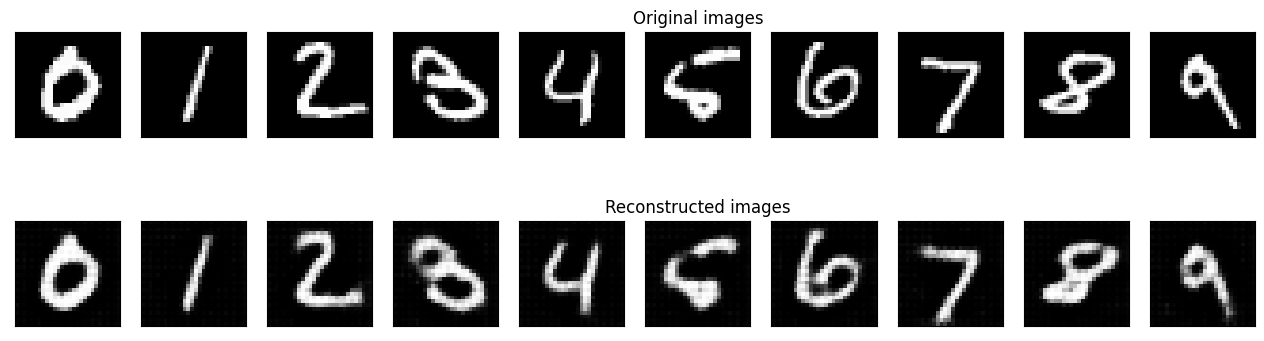

	 partial train loss (single batch): 0.009128
	 partial train loss (single batch): 0.009167
	 partial train loss (single batch): 0.008631
	 partial train loss (single batch): 0.009166
	 partial train loss (single batch): 0.008513
	 partial train loss (single batch): 0.009082
	 partial train loss (single batch): 0.008779
	 partial train loss (single batch): 0.008856
	 partial train loss (single batch): 0.008559
	 partial train loss (single batch): 0.008864
	 partial train loss (single batch): 0.009078
	 partial train loss (single batch): 0.008646
	 partial train loss (single batch): 0.008379
	 partial train loss (single batch): 0.008393
	 partial train loss (single batch): 0.008471
	 partial train loss (single batch): 0.008842
	 partial train loss (single batch): 0.009035
	 partial train loss (single batch): 0.008909
	 partial train loss (single batch): 0.009078
	 partial train loss (single batch): 0.008430
	 partial train loss (single batch): 0.008654
	 partial train loss (single batch

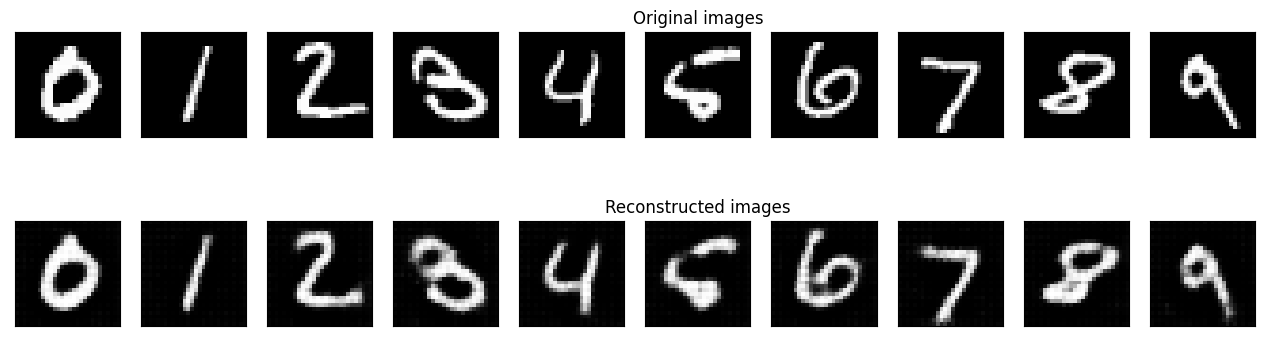

	 partial train loss (single batch): 0.008745
	 partial train loss (single batch): 0.008814
	 partial train loss (single batch): 0.008277
	 partial train loss (single batch): 0.008797
	 partial train loss (single batch): 0.008094
	 partial train loss (single batch): 0.008684
	 partial train loss (single batch): 0.008405
	 partial train loss (single batch): 0.008407
	 partial train loss (single batch): 0.008239
	 partial train loss (single batch): 0.008491
	 partial train loss (single batch): 0.008644
	 partial train loss (single batch): 0.008268
	 partial train loss (single batch): 0.008011
	 partial train loss (single batch): 0.008011
	 partial train loss (single batch): 0.008151
	 partial train loss (single batch): 0.008489
	 partial train loss (single batch): 0.008611
	 partial train loss (single batch): 0.008607
	 partial train loss (single batch): 0.008662
	 partial train loss (single batch): 0.008098
	 partial train loss (single batch): 0.008288
	 partial train loss (single batch

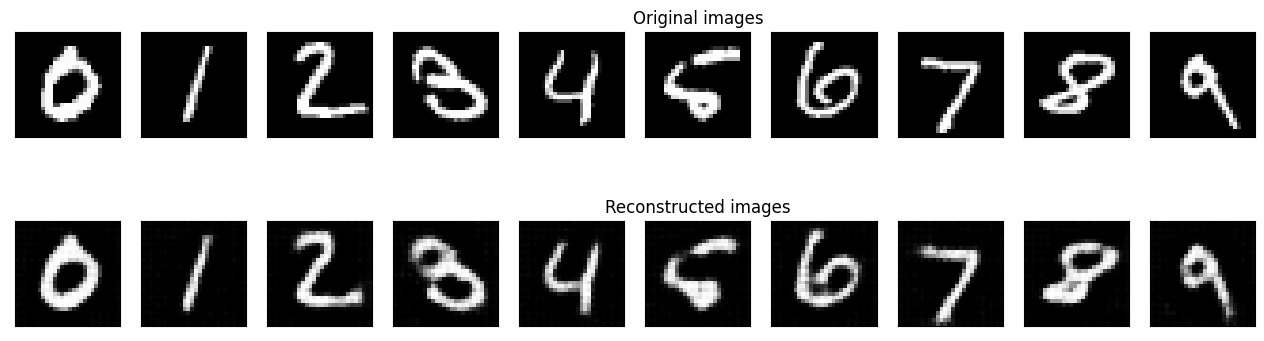

	 partial train loss (single batch): 0.008483
	 partial train loss (single batch): 0.008593
	 partial train loss (single batch): 0.007966
	 partial train loss (single batch): 0.008514
	 partial train loss (single batch): 0.007844
	 partial train loss (single batch): 0.008459
	 partial train loss (single batch): 0.008184
	 partial train loss (single batch): 0.008163
	 partial train loss (single batch): 0.008053
	 partial train loss (single batch): 0.008236
	 partial train loss (single batch): 0.008433
	 partial train loss (single batch): 0.007997
	 partial train loss (single batch): 0.007811
	 partial train loss (single batch): 0.007768
	 partial train loss (single batch): 0.007938
	 partial train loss (single batch): 0.008240
	 partial train loss (single batch): 0.008355
	 partial train loss (single batch): 0.008370
	 partial train loss (single batch): 0.008413
	 partial train loss (single batch): 0.007914
	 partial train loss (single batch): 0.008005
	 partial train loss (single batch

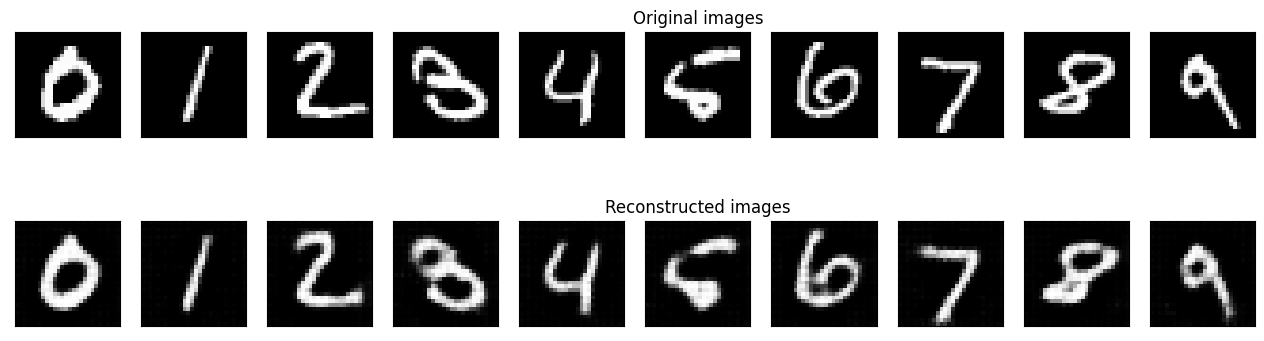

	 partial train loss (single batch): 0.008208
	 partial train loss (single batch): 0.008343
	 partial train loss (single batch): 0.007764
	 partial train loss (single batch): 0.008276
	 partial train loss (single batch): 0.007671
	 partial train loss (single batch): 0.008184
	 partial train loss (single batch): 0.007940
	 partial train loss (single batch): 0.007921
	 partial train loss (single batch): 0.007792
	 partial train loss (single batch): 0.008027
	 partial train loss (single batch): 0.008142
	 partial train loss (single batch): 0.007781
	 partial train loss (single batch): 0.007607
	 partial train loss (single batch): 0.007580
	 partial train loss (single batch): 0.007678
	 partial train loss (single batch): 0.008066
	 partial train loss (single batch): 0.008050
	 partial train loss (single batch): 0.008212
	 partial train loss (single batch): 0.008156
	 partial train loss (single batch): 0.007683
	 partial train loss (single batch): 0.007730
	 partial train loss (single batch

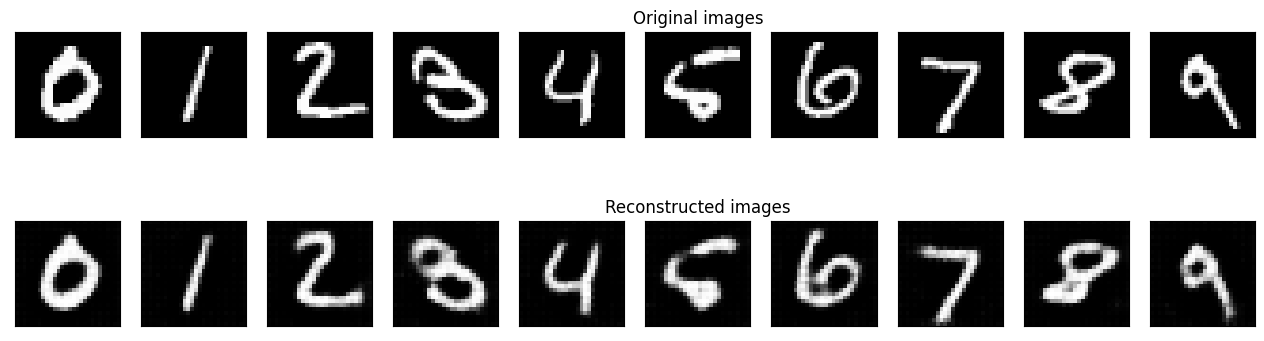

	 partial train loss (single batch): 0.008050
	 partial train loss (single batch): 0.008129
	 partial train loss (single batch): 0.007551
	 partial train loss (single batch): 0.008113
	 partial train loss (single batch): 0.007457
	 partial train loss (single batch): 0.007983
	 partial train loss (single batch): 0.007755
	 partial train loss (single batch): 0.007726
	 partial train loss (single batch): 0.007622
	 partial train loss (single batch): 0.007861
	 partial train loss (single batch): 0.007949
	 partial train loss (single batch): 0.007594
	 partial train loss (single batch): 0.007465
	 partial train loss (single batch): 0.007402
	 partial train loss (single batch): 0.007546
	 partial train loss (single batch): 0.007867
	 partial train loss (single batch): 0.007850
	 partial train loss (single batch): 0.007994
	 partial train loss (single batch): 0.008019
	 partial train loss (single batch): 0.007497
	 partial train loss (single batch): 0.007553
	 partial train loss (single batch

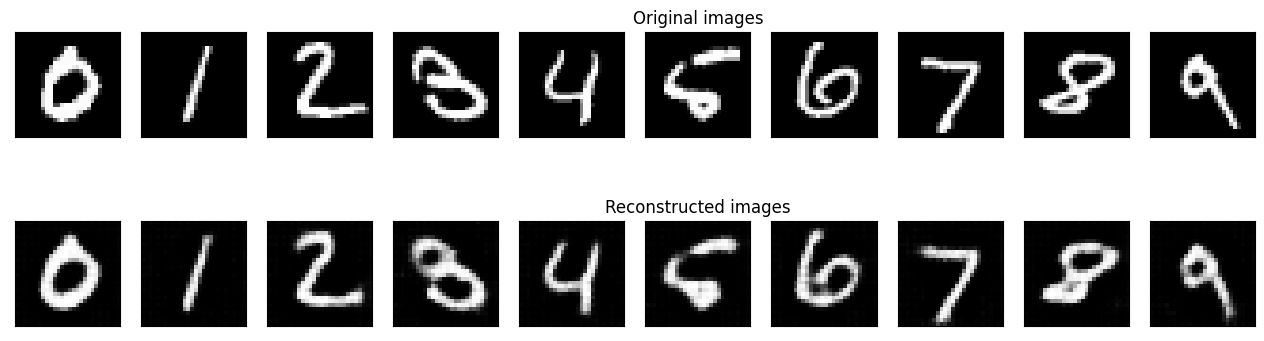

	 partial train loss (single batch): 0.007839
	 partial train loss (single batch): 0.007914
	 partial train loss (single batch): 0.007338
	 partial train loss (single batch): 0.007897
	 partial train loss (single batch): 0.007266
	 partial train loss (single batch): 0.007798
	 partial train loss (single batch): 0.007574
	 partial train loss (single batch): 0.007527
	 partial train loss (single batch): 0.007434
	 partial train loss (single batch): 0.007717
	 partial train loss (single batch): 0.007713
	 partial train loss (single batch): 0.007467
	 partial train loss (single batch): 0.007227
	 partial train loss (single batch): 0.007286
	 partial train loss (single batch): 0.007361
	 partial train loss (single batch): 0.007653
	 partial train loss (single batch): 0.007665
	 partial train loss (single batch): 0.007765
	 partial train loss (single batch): 0.007846
	 partial train loss (single batch): 0.007311
	 partial train loss (single batch): 0.007381
	 partial train loss (single batch

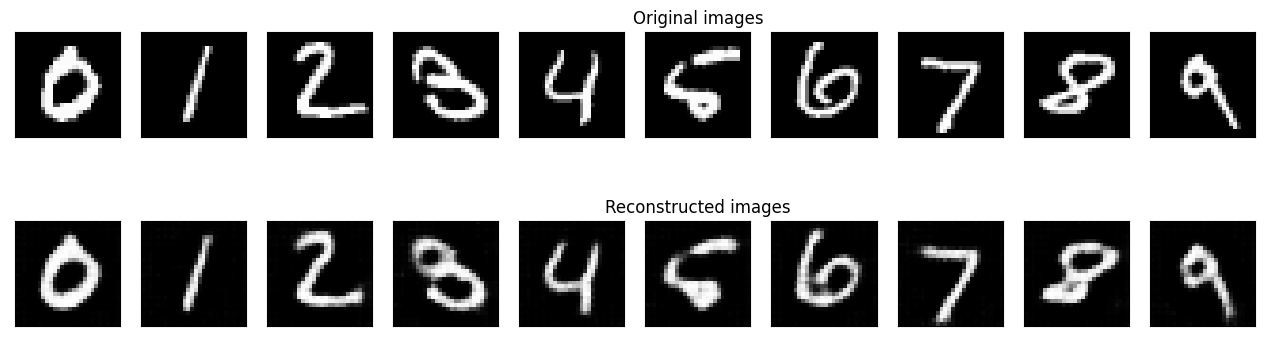

	 partial train loss (single batch): 0.007680
	 partial train loss (single batch): 0.007770
	 partial train loss (single batch): 0.007160
	 partial train loss (single batch): 0.007742
	 partial train loss (single batch): 0.007110
	 partial train loss (single batch): 0.007635
	 partial train loss (single batch): 0.007443
	 partial train loss (single batch): 0.007360
	 partial train loss (single batch): 0.007277
	 partial train loss (single batch): 0.007576
	 partial train loss (single batch): 0.007554
	 partial train loss (single batch): 0.007251
	 partial train loss (single batch): 0.007044
	 partial train loss (single batch): 0.007141
	 partial train loss (single batch): 0.007214
	 partial train loss (single batch): 0.007421
	 partial train loss (single batch): 0.007531
	 partial train loss (single batch): 0.007531
	 partial train loss (single batch): 0.007643
	 partial train loss (single batch): 0.007128
	 partial train loss (single batch): 0.007227
	 partial train loss (single batch

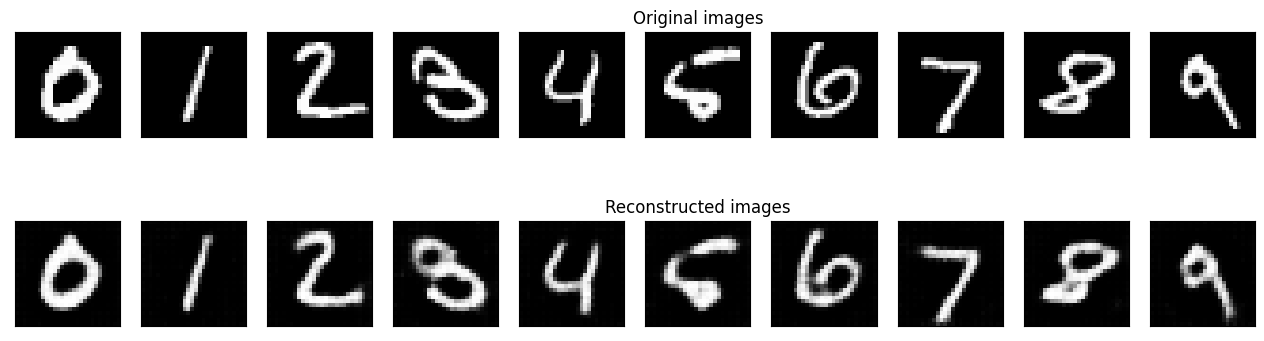

	 partial train loss (single batch): 0.007569
	 partial train loss (single batch): 0.007574
	 partial train loss (single batch): 0.007044
	 partial train loss (single batch): 0.007614
	 partial train loss (single batch): 0.006981
	 partial train loss (single batch): 0.007484
	 partial train loss (single batch): 0.007368
	 partial train loss (single batch): 0.007161
	 partial train loss (single batch): 0.007160
	 partial train loss (single batch): 0.007425
	 partial train loss (single batch): 0.007395
	 partial train loss (single batch): 0.007107
	 partial train loss (single batch): 0.006903
	 partial train loss (single batch): 0.007052
	 partial train loss (single batch): 0.007070
	 partial train loss (single batch): 0.007268
	 partial train loss (single batch): 0.007411
	 partial train loss (single batch): 0.007306
	 partial train loss (single batch): 0.007469
	 partial train loss (single batch): 0.007031
	 partial train loss (single batch): 0.007064
	 partial train loss (single batch

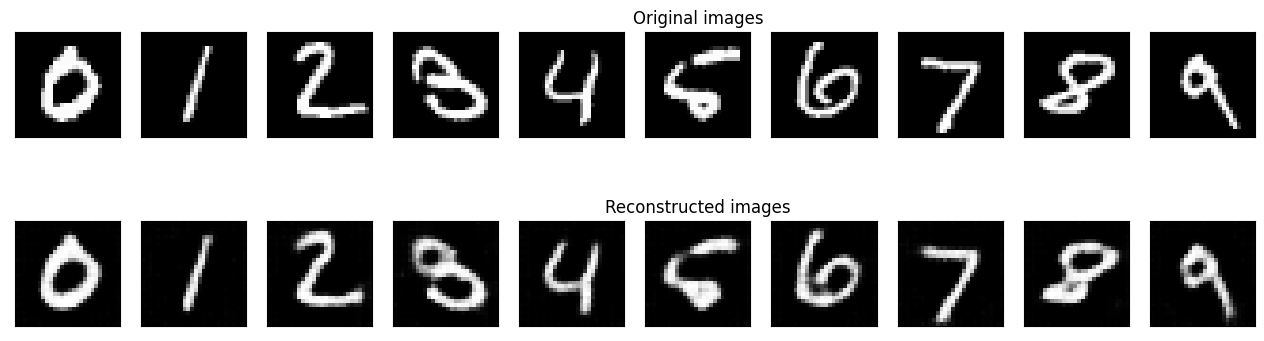

	 partial train loss (single batch): 0.007462
	 partial train loss (single batch): 0.007409
	 partial train loss (single batch): 0.006955
	 partial train loss (single batch): 0.007471
	 partial train loss (single batch): 0.006886
	 partial train loss (single batch): 0.007371
	 partial train loss (single batch): 0.007243
	 partial train loss (single batch): 0.007024
	 partial train loss (single batch): 0.007077
	 partial train loss (single batch): 0.007320
	 partial train loss (single batch): 0.007272
	 partial train loss (single batch): 0.007024
	 partial train loss (single batch): 0.006793
	 partial train loss (single batch): 0.007020
	 partial train loss (single batch): 0.006942
	 partial train loss (single batch): 0.007231
	 partial train loss (single batch): 0.007322
	 partial train loss (single batch): 0.007167
	 partial train loss (single batch): 0.007427
	 partial train loss (single batch): 0.006927
	 partial train loss (single batch): 0.006987
	 partial train loss (single batch

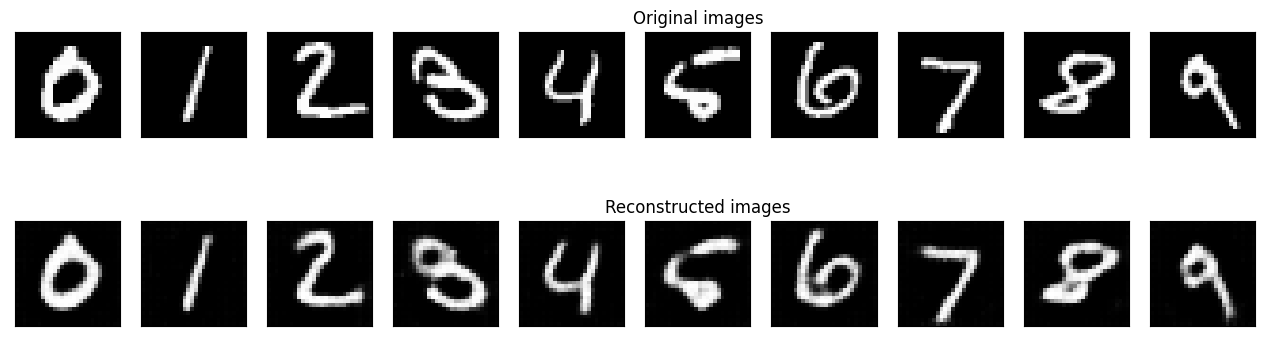

	 partial train loss (single batch): 0.007345
	 partial train loss (single batch): 0.007289
	 partial train loss (single batch): 0.006868
	 partial train loss (single batch): 0.007354
	 partial train loss (single batch): 0.006789
	 partial train loss (single batch): 0.007238
	 partial train loss (single batch): 0.007136
	 partial train loss (single batch): 0.006890
	 partial train loss (single batch): 0.006989
	 partial train loss (single batch): 0.007188
	 partial train loss (single batch): 0.007175
	 partial train loss (single batch): 0.006898
	 partial train loss (single batch): 0.006687
	 partial train loss (single batch): 0.006902
	 partial train loss (single batch): 0.006820
	 partial train loss (single batch): 0.007157
	 partial train loss (single batch): 0.007205
	 partial train loss (single batch): 0.007029
	 partial train loss (single batch): 0.007317
	 partial train loss (single batch): 0.006799
	 partial train loss (single batch): 0.006867
	 partial train loss (single batch

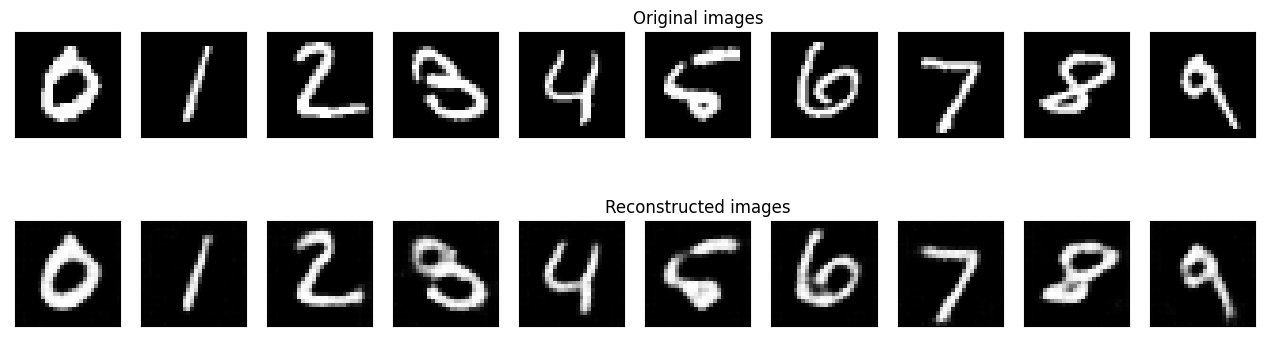

	 partial train loss (single batch): 0.007220
	 partial train loss (single batch): 0.007195
	 partial train loss (single batch): 0.006783
	 partial train loss (single batch): 0.007292
	 partial train loss (single batch): 0.006691
	 partial train loss (single batch): 0.007151
	 partial train loss (single batch): 0.007048
	 partial train loss (single batch): 0.006771
	 partial train loss (single batch): 0.006949
	 partial train loss (single batch): 0.007046
	 partial train loss (single batch): 0.007079
	 partial train loss (single batch): 0.006815
	 partial train loss (single batch): 0.006617
	 partial train loss (single batch): 0.006822
	 partial train loss (single batch): 0.006731
	 partial train loss (single batch): 0.007057
	 partial train loss (single batch): 0.007116
	 partial train loss (single batch): 0.006953
	 partial train loss (single batch): 0.007234
	 partial train loss (single batch): 0.006718
	 partial train loss (single batch): 0.006783
	 partial train loss (single batch

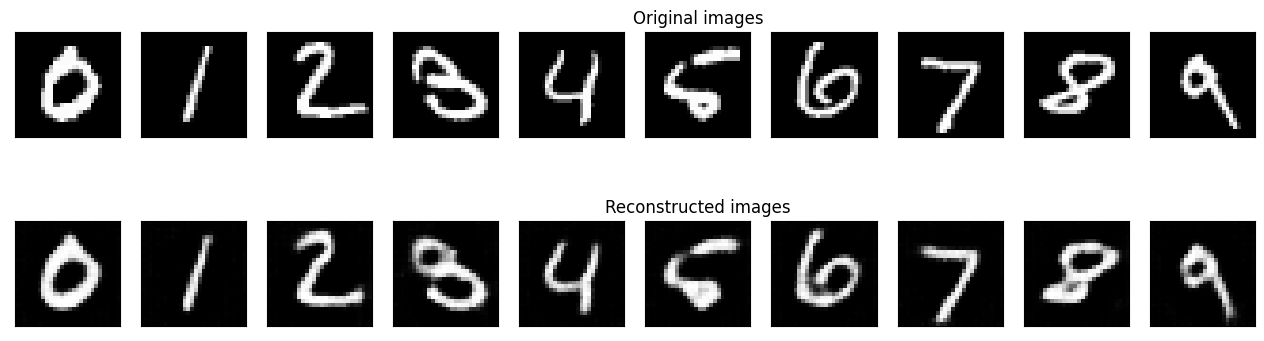

	 partial train loss (single batch): 0.007080
	 partial train loss (single batch): 0.007092
	 partial train loss (single batch): 0.006693
	 partial train loss (single batch): 0.007160
	 partial train loss (single batch): 0.006578
	 partial train loss (single batch): 0.007071
	 partial train loss (single batch): 0.006933
	 partial train loss (single batch): 0.006670
	 partial train loss (single batch): 0.006864
	 partial train loss (single batch): 0.006896
	 partial train loss (single batch): 0.006997
	 partial train loss (single batch): 0.006704
	 partial train loss (single batch): 0.006530
	 partial train loss (single batch): 0.006711
	 partial train loss (single batch): 0.006627
	 partial train loss (single batch): 0.006966
	 partial train loss (single batch): 0.007047
	 partial train loss (single batch): 0.006866
	 partial train loss (single batch): 0.007148
	 partial train loss (single batch): 0.006645
	 partial train loss (single batch): 0.006683
	 partial train loss (single batch

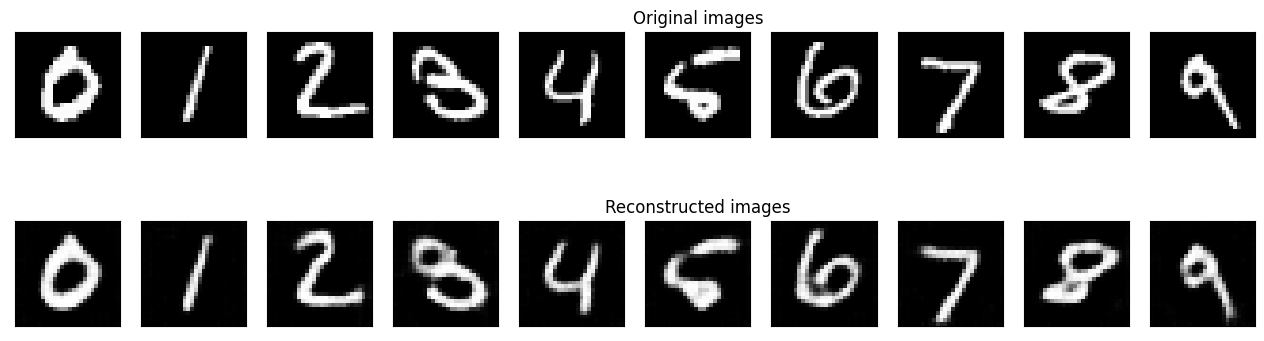

	 partial train loss (single batch): 0.006995
	 partial train loss (single batch): 0.006981
	 partial train loss (single batch): 0.006661
	 partial train loss (single batch): 0.007025
	 partial train loss (single batch): 0.006490
	 partial train loss (single batch): 0.006976
	 partial train loss (single batch): 0.006862
	 partial train loss (single batch): 0.006571
	 partial train loss (single batch): 0.006846
	 partial train loss (single batch): 0.006797
	 partial train loss (single batch): 0.006889
	 partial train loss (single batch): 0.006635
	 partial train loss (single batch): 0.006471
	 partial train loss (single batch): 0.006613
	 partial train loss (single batch): 0.006583
	 partial train loss (single batch): 0.006843
	 partial train loss (single batch): 0.006988
	 partial train loss (single batch): 0.006777
	 partial train loss (single batch): 0.007057
	 partial train loss (single batch): 0.006552
	 partial train loss (single batch): 0.006573
	 partial train loss (single batch

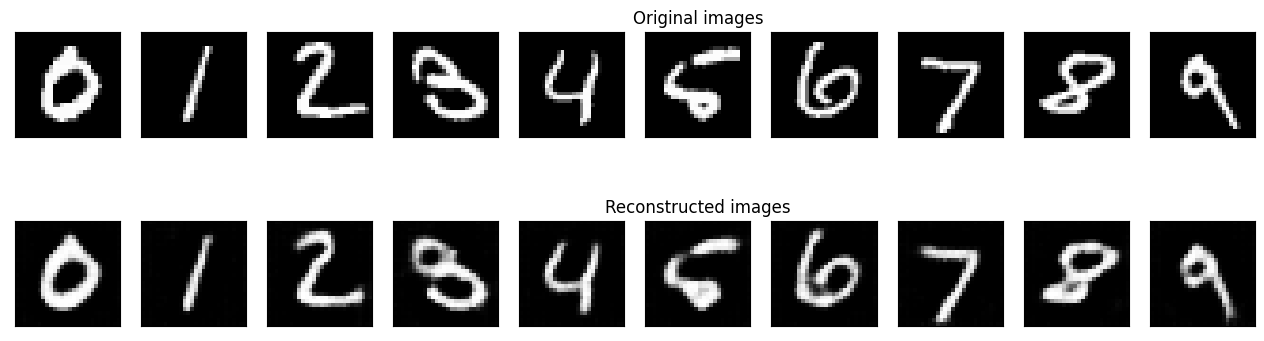

	 partial train loss (single batch): 0.006922
	 partial train loss (single batch): 0.006881
	 partial train loss (single batch): 0.006608
	 partial train loss (single batch): 0.006925
	 partial train loss (single batch): 0.006436
	 partial train loss (single batch): 0.006890
	 partial train loss (single batch): 0.006797
	 partial train loss (single batch): 0.006505
	 partial train loss (single batch): 0.006793
	 partial train loss (single batch): 0.006698
	 partial train loss (single batch): 0.006829
	 partial train loss (single batch): 0.006580
	 partial train loss (single batch): 0.006393
	 partial train loss (single batch): 0.006527
	 partial train loss (single batch): 0.006488
	 partial train loss (single batch): 0.006714
	 partial train loss (single batch): 0.006941
	 partial train loss (single batch): 0.006679
	 partial train loss (single batch): 0.006963
	 partial train loss (single batch): 0.006478
	 partial train loss (single batch): 0.006464
	 partial train loss (single batch

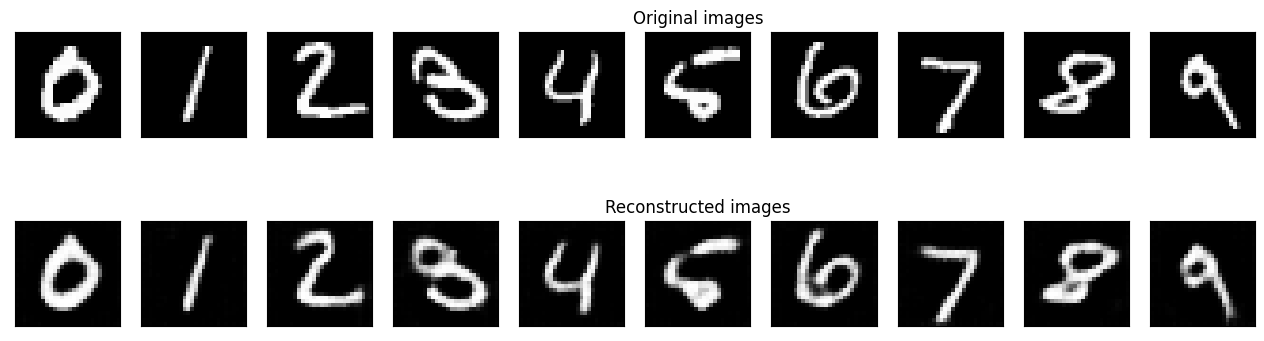

	 partial train loss (single batch): 0.006808
	 partial train loss (single batch): 0.006803
	 partial train loss (single batch): 0.006536
	 partial train loss (single batch): 0.006831
	 partial train loss (single batch): 0.006389
	 partial train loss (single batch): 0.006833
	 partial train loss (single batch): 0.006735
	 partial train loss (single batch): 0.006459
	 partial train loss (single batch): 0.006761
	 partial train loss (single batch): 0.006583
	 partial train loss (single batch): 0.006775
	 partial train loss (single batch): 0.006519
	 partial train loss (single batch): 0.006298
	 partial train loss (single batch): 0.006481
	 partial train loss (single batch): 0.006363
	 partial train loss (single batch): 0.006658
	 partial train loss (single batch): 0.006868
	 partial train loss (single batch): 0.006609
	 partial train loss (single batch): 0.006866
	 partial train loss (single batch): 0.006451
	 partial train loss (single batch): 0.006355
	 partial train loss (single batch

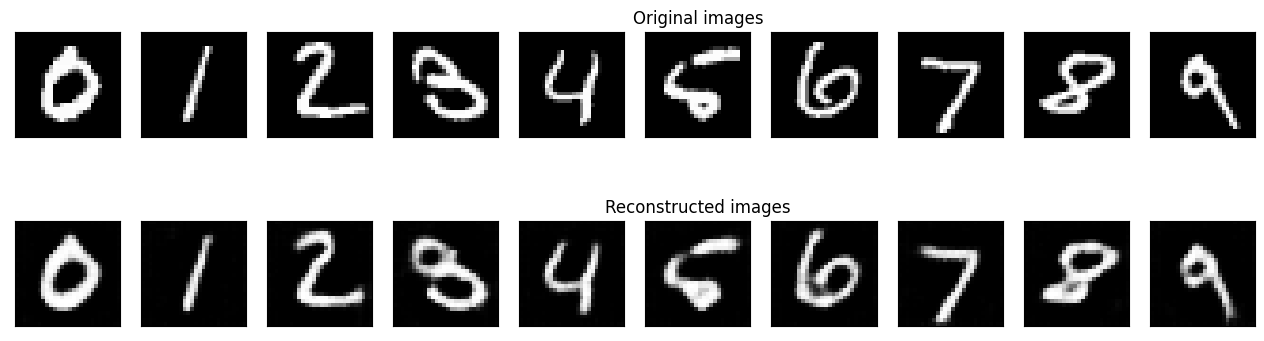

	 partial train loss (single batch): 0.006689
	 partial train loss (single batch): 0.006702
	 partial train loss (single batch): 0.006405
	 partial train loss (single batch): 0.006757
	 partial train loss (single batch): 0.006309
	 partial train loss (single batch): 0.006761
	 partial train loss (single batch): 0.006639
	 partial train loss (single batch): 0.006395
	 partial train loss (single batch): 0.006655
	 partial train loss (single batch): 0.006485
	 partial train loss (single batch): 0.006711
	 partial train loss (single batch): 0.006416
	 partial train loss (single batch): 0.006222
	 partial train loss (single batch): 0.006408
	 partial train loss (single batch): 0.006265
	 partial train loss (single batch): 0.006603
	 partial train loss (single batch): 0.006773
	 partial train loss (single batch): 0.006521
	 partial train loss (single batch): 0.006821
	 partial train loss (single batch): 0.006375
	 partial train loss (single batch): 0.006294
	 partial train loss (single batch

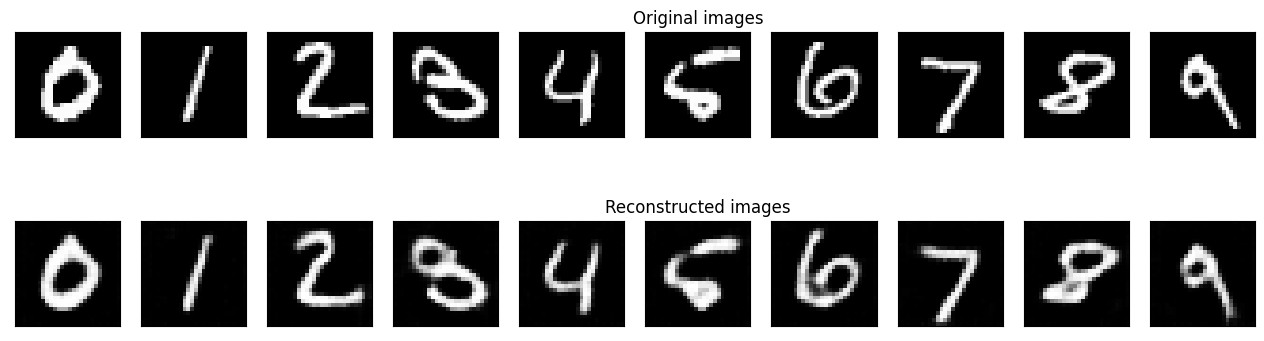

	 partial train loss (single batch): 0.006601
	 partial train loss (single batch): 0.006615
	 partial train loss (single batch): 0.006294
	 partial train loss (single batch): 0.006682
	 partial train loss (single batch): 0.006240
	 partial train loss (single batch): 0.006687
	 partial train loss (single batch): 0.006557
	 partial train loss (single batch): 0.006316
	 partial train loss (single batch): 0.006542
	 partial train loss (single batch): 0.006406
	 partial train loss (single batch): 0.006597
	 partial train loss (single batch): 0.006339
	 partial train loss (single batch): 0.006144
	 partial train loss (single batch): 0.006319
	 partial train loss (single batch): 0.006173
	 partial train loss (single batch): 0.006562
	 partial train loss (single batch): 0.006648
	 partial train loss (single batch): 0.006412
	 partial train loss (single batch): 0.006751
	 partial train loss (single batch): 0.006291
	 partial train loss (single batch): 0.006231
	 partial train loss (single batch

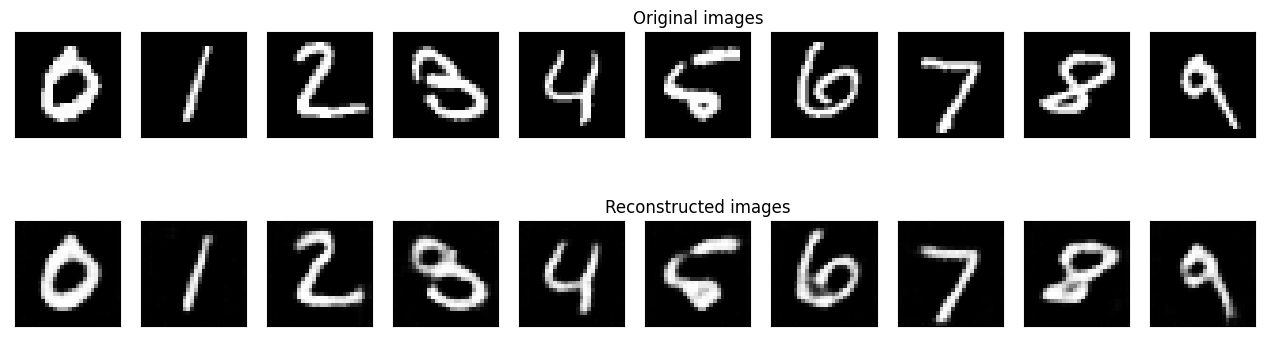

	 partial train loss (single batch): 0.006510
	 partial train loss (single batch): 0.006561
	 partial train loss (single batch): 0.006194
	 partial train loss (single batch): 0.006608
	 partial train loss (single batch): 0.006168
	 partial train loss (single batch): 0.006632
	 partial train loss (single batch): 0.006466
	 partial train loss (single batch): 0.006272
	 partial train loss (single batch): 0.006438
	 partial train loss (single batch): 0.006366
	 partial train loss (single batch): 0.006498
	 partial train loss (single batch): 0.006301
	 partial train loss (single batch): 0.006105
	 partial train loss (single batch): 0.006243
	 partial train loss (single batch): 0.006144
	 partial train loss (single batch): 0.006503
	 partial train loss (single batch): 0.006538
	 partial train loss (single batch): 0.006335
	 partial train loss (single batch): 0.006707
	 partial train loss (single batch): 0.006225
	 partial train loss (single batch): 0.006202
	 partial train loss (single batch

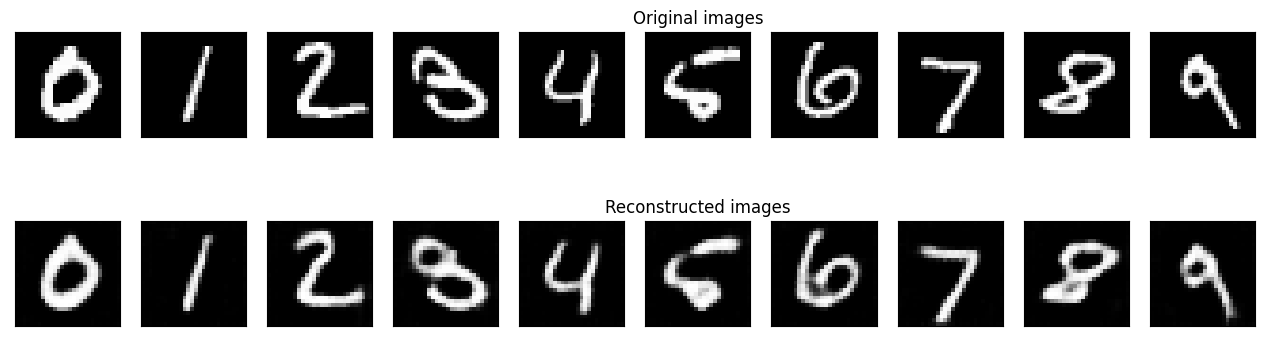

	 partial train loss (single batch): 0.006479
	 partial train loss (single batch): 0.006504
	 partial train loss (single batch): 0.006136
	 partial train loss (single batch): 0.006570
	 partial train loss (single batch): 0.006123
	 partial train loss (single batch): 0.006576
	 partial train loss (single batch): 0.006420
	 partial train loss (single batch): 0.006224
	 partial train loss (single batch): 0.006400
	 partial train loss (single batch): 0.006285
	 partial train loss (single batch): 0.006482
	 partial train loss (single batch): 0.006267
	 partial train loss (single batch): 0.006086
	 partial train loss (single batch): 0.006201
	 partial train loss (single batch): 0.006140
	 partial train loss (single batch): 0.006436
	 partial train loss (single batch): 0.006530
	 partial train loss (single batch): 0.006252
	 partial train loss (single batch): 0.006690
	 partial train loss (single batch): 0.006189
	 partial train loss (single batch): 0.006181
	 partial train loss (single batch

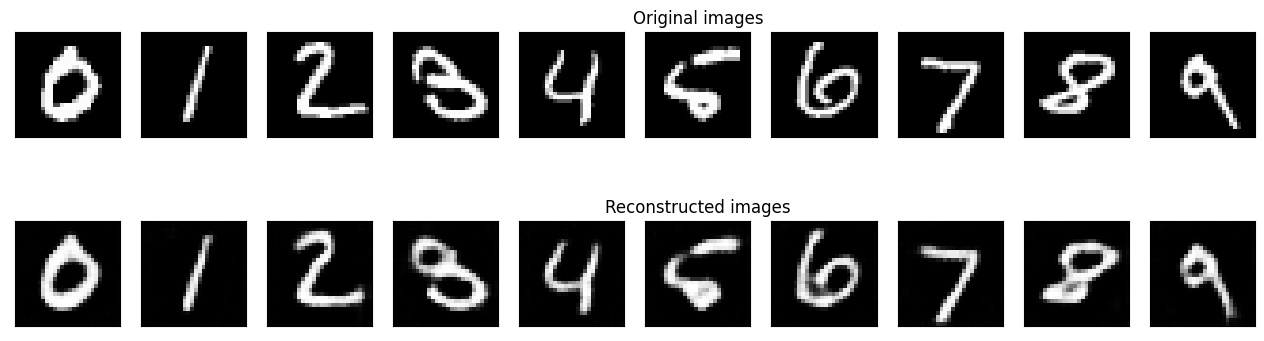

	 partial train loss (single batch): 0.006448
	 partial train loss (single batch): 0.006435
	 partial train loss (single batch): 0.006095
	 partial train loss (single batch): 0.006507
	 partial train loss (single batch): 0.006096
	 partial train loss (single batch): 0.006525
	 partial train loss (single batch): 0.006337
	 partial train loss (single batch): 0.006173
	 partial train loss (single batch): 0.006360
	 partial train loss (single batch): 0.006239
	 partial train loss (single batch): 0.006416
	 partial train loss (single batch): 0.006228
	 partial train loss (single batch): 0.006031
	 partial train loss (single batch): 0.006162
	 partial train loss (single batch): 0.006091
	 partial train loss (single batch): 0.006395
	 partial train loss (single batch): 0.006488
	 partial train loss (single batch): 0.006190
	 partial train loss (single batch): 0.006652
	 partial train loss (single batch): 0.006123
	 partial train loss (single batch): 0.006158
	 partial train loss (single batch

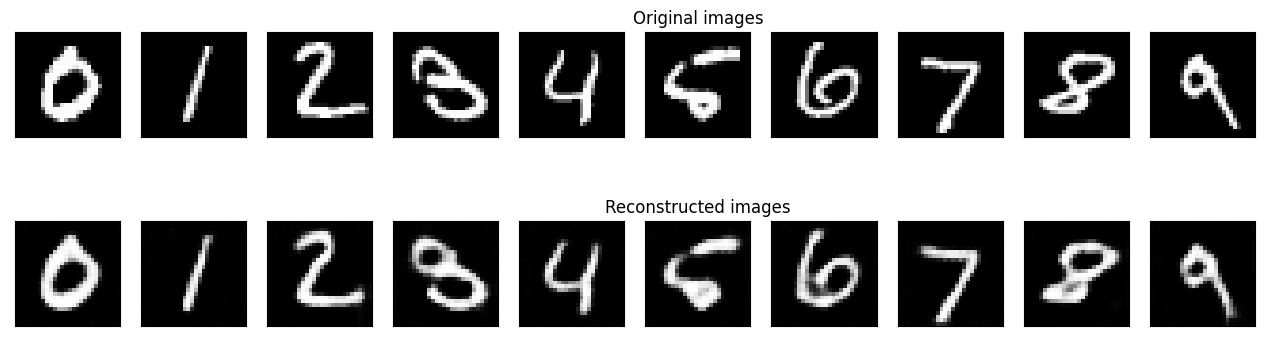

	 partial train loss (single batch): 0.006410
	 partial train loss (single batch): 0.006339
	 partial train loss (single batch): 0.006042
	 partial train loss (single batch): 0.006441
	 partial train loss (single batch): 0.006044
	 partial train loss (single batch): 0.006470
	 partial train loss (single batch): 0.006231
	 partial train loss (single batch): 0.006133
	 partial train loss (single batch): 0.006258
	 partial train loss (single batch): 0.006178
	 partial train loss (single batch): 0.006354
	 partial train loss (single batch): 0.006155
	 partial train loss (single batch): 0.005959
	 partial train loss (single batch): 0.006113
	 partial train loss (single batch): 0.006018
	 partial train loss (single batch): 0.006329
	 partial train loss (single batch): 0.006388
	 partial train loss (single batch): 0.006131
	 partial train loss (single batch): 0.006564
	 partial train loss (single batch): 0.006094
	 partial train loss (single batch): 0.006075
	 partial train loss (single batch

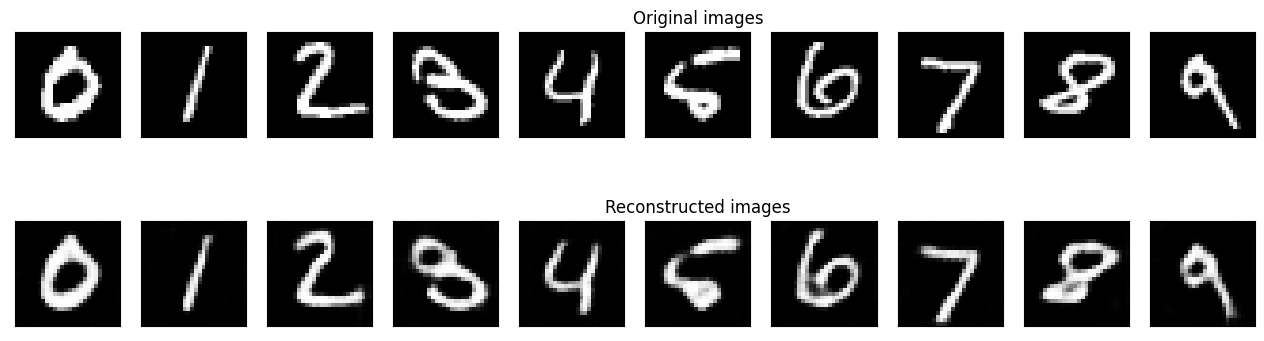

	 partial train loss (single batch): 0.006384
	 partial train loss (single batch): 0.006273
	 partial train loss (single batch): 0.006034
	 partial train loss (single batch): 0.006405
	 partial train loss (single batch): 0.006004
	 partial train loss (single batch): 0.006428
	 partial train loss (single batch): 0.006175
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.006202
	 partial train loss (single batch): 0.006161
	 partial train loss (single batch): 0.006278
	 partial train loss (single batch): 0.006094
	 partial train loss (single batch): 0.005935
	 partial train loss (single batch): 0.006046
	 partial train loss (single batch): 0.005988
	 partial train loss (single batch): 0.006260
	 partial train loss (single batch): 0.006341
	 partial train loss (single batch): 0.006073
	 partial train loss (single batch): 0.006518
	 partial train loss (single batch): 0.006057
	 partial train loss (single batch): 0.006013
	 partial train loss (single batch

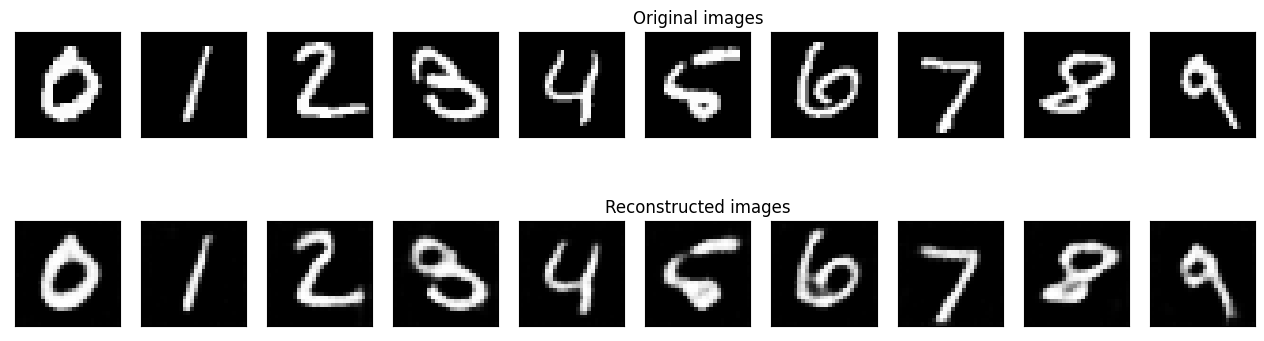

	 partial train loss (single batch): 0.006302
	 partial train loss (single batch): 0.006222
	 partial train loss (single batch): 0.005989
	 partial train loss (single batch): 0.006340
	 partial train loss (single batch): 0.005985
	 partial train loss (single batch): 0.006386
	 partial train loss (single batch): 0.006127
	 partial train loss (single batch): 0.006084
	 partial train loss (single batch): 0.006147
	 partial train loss (single batch): 0.006110
	 partial train loss (single batch): 0.006221
	 partial train loss (single batch): 0.006058
	 partial train loss (single batch): 0.005883
	 partial train loss (single batch): 0.005994
	 partial train loss (single batch): 0.005940
	 partial train loss (single batch): 0.006195
	 partial train loss (single batch): 0.006308
	 partial train loss (single batch): 0.006012
	 partial train loss (single batch): 0.006497
	 partial train loss (single batch): 0.006012
	 partial train loss (single batch): 0.005982
	 partial train loss (single batch

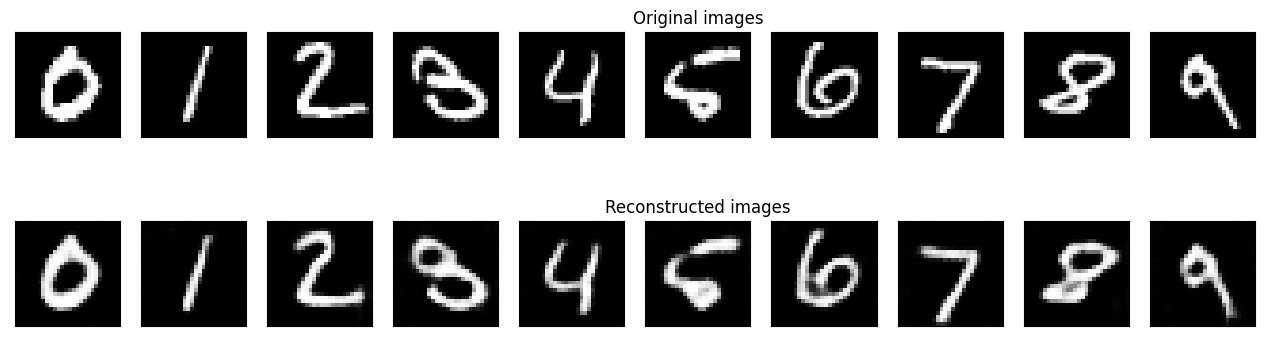

	 partial train loss (single batch): 0.006239
	 partial train loss (single batch): 0.006194
	 partial train loss (single batch): 0.005923
	 partial train loss (single batch): 0.006295
	 partial train loss (single batch): 0.005961
	 partial train loss (single batch): 0.006323
	 partial train loss (single batch): 0.006097
	 partial train loss (single batch): 0.006039
	 partial train loss (single batch): 0.006103
	 partial train loss (single batch): 0.006109
	 partial train loss (single batch): 0.006132
	 partial train loss (single batch): 0.006056
	 partial train loss (single batch): 0.005832
	 partial train loss (single batch): 0.005982
	 partial train loss (single batch): 0.005903
	 partial train loss (single batch): 0.006198
	 partial train loss (single batch): 0.006284
	 partial train loss (single batch): 0.005953
	 partial train loss (single batch): 0.006502
	 partial train loss (single batch): 0.005938
	 partial train loss (single batch): 0.005977
	 partial train loss (single batch

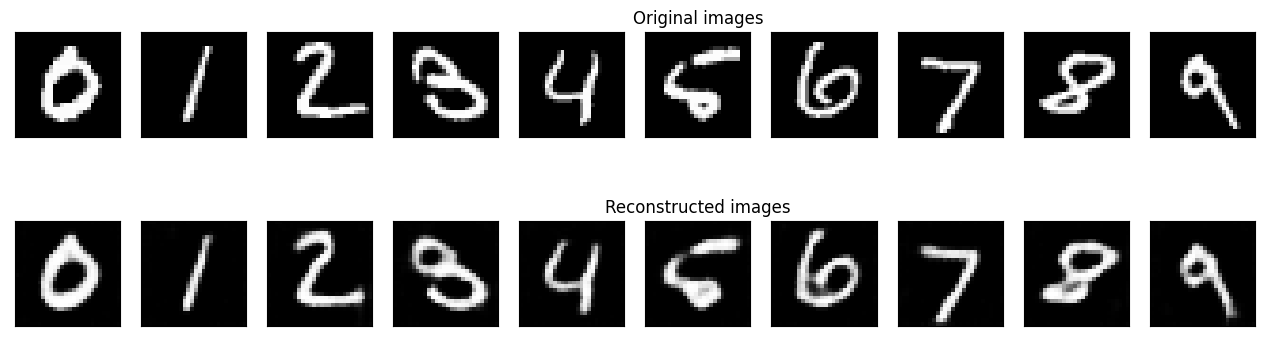

	 partial train loss (single batch): 0.006298
	 partial train loss (single batch): 0.006257
	 partial train loss (single batch): 0.005991
	 partial train loss (single batch): 0.006254
	 partial train loss (single batch): 0.005885
	 partial train loss (single batch): 0.006335
	 partial train loss (single batch): 0.006040
	 partial train loss (single batch): 0.006088
	 partial train loss (single batch): 0.006037
	 partial train loss (single batch): 0.006052
	 partial train loss (single batch): 0.006111
	 partial train loss (single batch): 0.005957
	 partial train loss (single batch): 0.005789
	 partial train loss (single batch): 0.006010
	 partial train loss (single batch): 0.005723
	 partial train loss (single batch): 0.006270
	 partial train loss (single batch): 0.006087
	 partial train loss (single batch): 0.006054
	 partial train loss (single batch): 0.006336
	 partial train loss (single batch): 0.005846
	 partial train loss (single batch): 0.005836
	 partial train loss (single batch

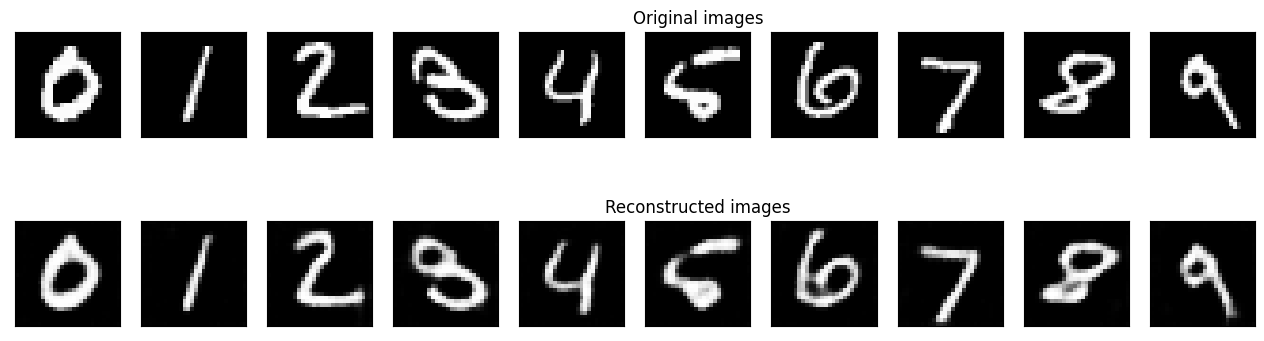

	 partial train loss (single batch): 0.006185
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.005858
	 partial train loss (single batch): 0.006172
	 partial train loss (single batch): 0.005835
	 partial train loss (single batch): 0.006207
	 partial train loss (single batch): 0.005963
	 partial train loss (single batch): 0.005958
	 partial train loss (single batch): 0.005978
	 partial train loss (single batch): 0.005982
	 partial train loss (single batch): 0.006056
	 partial train loss (single batch): 0.005905
	 partial train loss (single batch): 0.005785
	 partial train loss (single batch): 0.005888
	 partial train loss (single batch): 0.005787
	 partial train loss (single batch): 0.006148
	 partial train loss (single batch): 0.006108
	 partial train loss (single batch): 0.005969
	 partial train loss (single batch): 0.006296
	 partial train loss (single batch): 0.005837
	 partial train loss (single batch): 0.005820
	 partial train loss (single batch

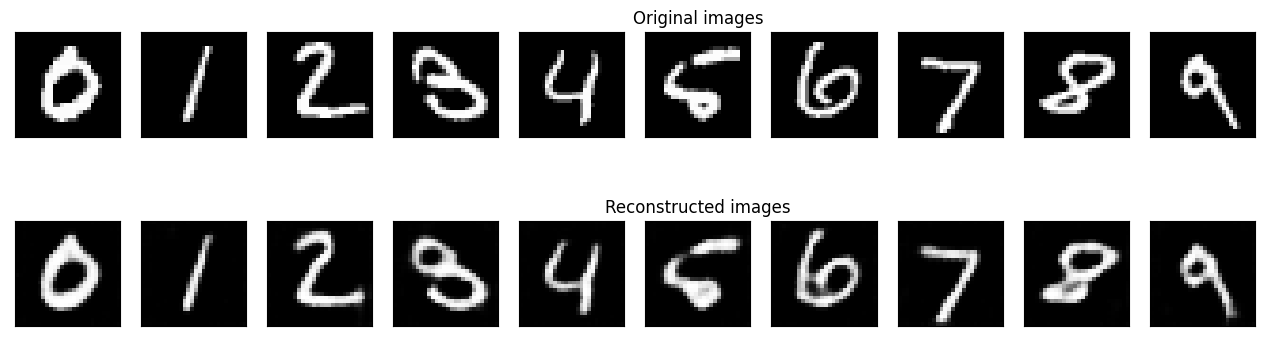

	 partial train loss (single batch): 0.006122
	 partial train loss (single batch): 0.006075
	 partial train loss (single batch): 0.005805
	 partial train loss (single batch): 0.006150
	 partial train loss (single batch): 0.005812
	 partial train loss (single batch): 0.006155
	 partial train loss (single batch): 0.005949
	 partial train loss (single batch): 0.005915
	 partial train loss (single batch): 0.005955
	 partial train loss (single batch): 0.005961
	 partial train loss (single batch): 0.006006
	 partial train loss (single batch): 0.005889
	 partial train loss (single batch): 0.005742
	 partial train loss (single batch): 0.005876
	 partial train loss (single batch): 0.005735
	 partial train loss (single batch): 0.006139
	 partial train loss (single batch): 0.006078
	 partial train loss (single batch): 0.005945
	 partial train loss (single batch): 0.006261
	 partial train loss (single batch): 0.005791
	 partial train loss (single batch): 0.005788
	 partial train loss (single batch

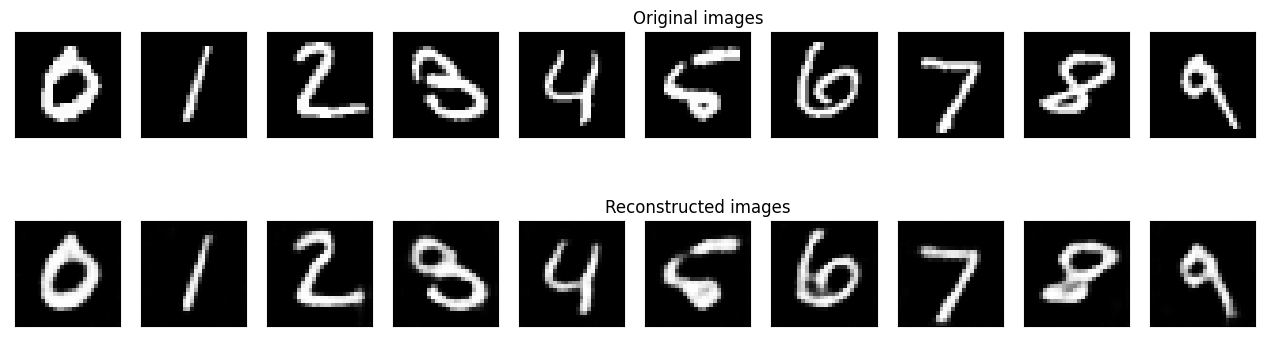

	 partial train loss (single batch): 0.006179
	 partial train loss (single batch): 0.006137
	 partial train loss (single batch): 0.005856
	 partial train loss (single batch): 0.006169
	 partial train loss (single batch): 0.005836
	 partial train loss (single batch): 0.006142
	 partial train loss (single batch): 0.006065
	 partial train loss (single batch): 0.005882
	 partial train loss (single batch): 0.005953
	 partial train loss (single batch): 0.005939
	 partial train loss (single batch): 0.005976
	 partial train loss (single batch): 0.005869
	 partial train loss (single batch): 0.005719
	 partial train loss (single batch): 0.005835
	 partial train loss (single batch): 0.005715
	 partial train loss (single batch): 0.006084
	 partial train loss (single batch): 0.006054
	 partial train loss (single batch): 0.005878
	 partial train loss (single batch): 0.006221
	 partial train loss (single batch): 0.005780
	 partial train loss (single batch): 0.005787
	 partial train loss (single batch

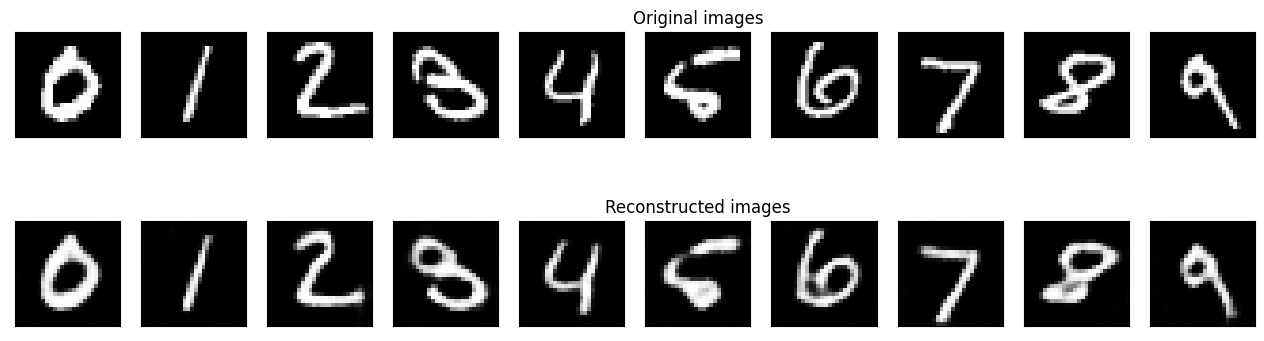

	 partial train loss (single batch): 0.006048
	 partial train loss (single batch): 0.006037
	 partial train loss (single batch): 0.005728
	 partial train loss (single batch): 0.006130
	 partial train loss (single batch): 0.005793
	 partial train loss (single batch): 0.006102
	 partial train loss (single batch): 0.005927
	 partial train loss (single batch): 0.005842
	 partial train loss (single batch): 0.005892
	 partial train loss (single batch): 0.005932
	 partial train loss (single batch): 0.005933
	 partial train loss (single batch): 0.005890
	 partial train loss (single batch): 0.005676
	 partial train loss (single batch): 0.005822
	 partial train loss (single batch): 0.005675
	 partial train loss (single batch): 0.006092
	 partial train loss (single batch): 0.006019
	 partial train loss (single batch): 0.005890
	 partial train loss (single batch): 0.006212
	 partial train loss (single batch): 0.005752
	 partial train loss (single batch): 0.005759
	 partial train loss (single batch

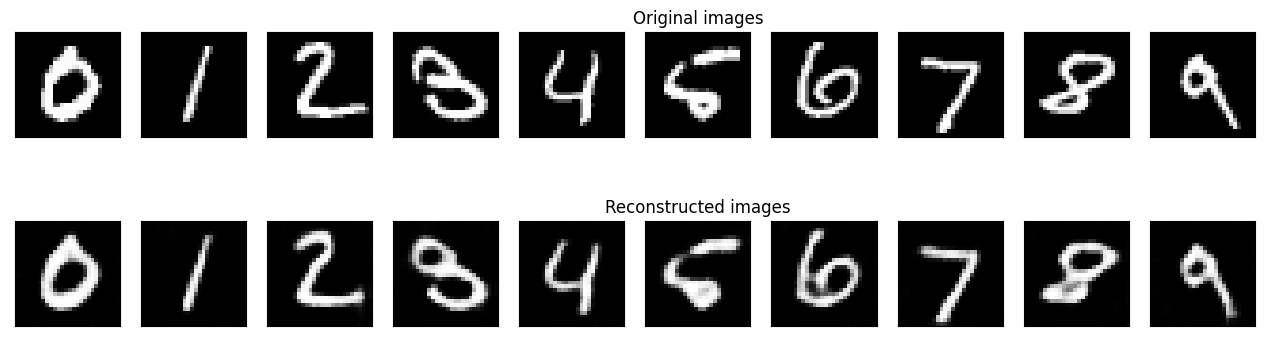

In [35]:
num_epochs = 40
diz_loss = {'train_loss':[],'val_loss':[]}
for epoch in range(num_epochs):
   train_loss =train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
   val_loss = test_epoch(encoder,decoder,device,test_loader,loss_fn)
   print('\n EPOCH {}/{} \t train loss {} \t val loss {}'.format(epoch + 1, num_epochs,train_loss,val_loss))
   diz_loss['train_loss'].append(train_loss)
   diz_loss['val_loss'].append(val_loss)
   plot_ae_outputs(encoder,decoder,n=10)

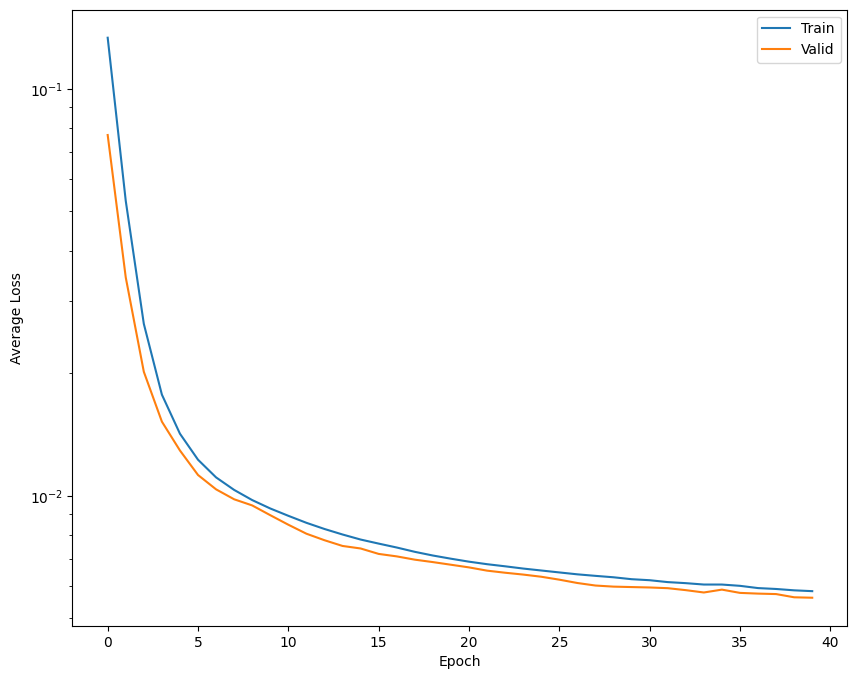

In [36]:
plt.figure(figsize=(10,8))
plt.semilogy(diz_loss['train_loss'], label='Train')
plt.semilogy(diz_loss['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

tensor([-0.1184,  0.0900, -0.0135, -0.1376, -0.0468, -0.0091,  0.1060, -0.1005,
         0.3023,  0.0691, -0.0646, -0.0730,  0.0350,  0.0388, -0.0283, -0.0093,
         0.0060, -0.0407, -0.0524, -0.1037, -0.0183,  0.0200,  0.0032, -0.0389,
        -0.2279, -0.0045,  0.0997,  0.0311, -0.0092, -0.0231,  0.0161,  0.0273])
tensor([0.1229, 0.1484, 0.1549, 0.1637, 0.1329, 0.1244, 0.1461, 0.1346, 0.1503,
        0.1525, 0.1370, 0.1633, 0.1730, 0.1628, 0.1455, 0.1580, 0.1611, 0.1455,
        0.1216, 0.1581, 0.1514, 0.1237, 0.1602, 0.1244, 0.1205, 0.1320, 0.1725,
        0.1550, 0.1372, 0.1863, 0.1364, 0.1681])


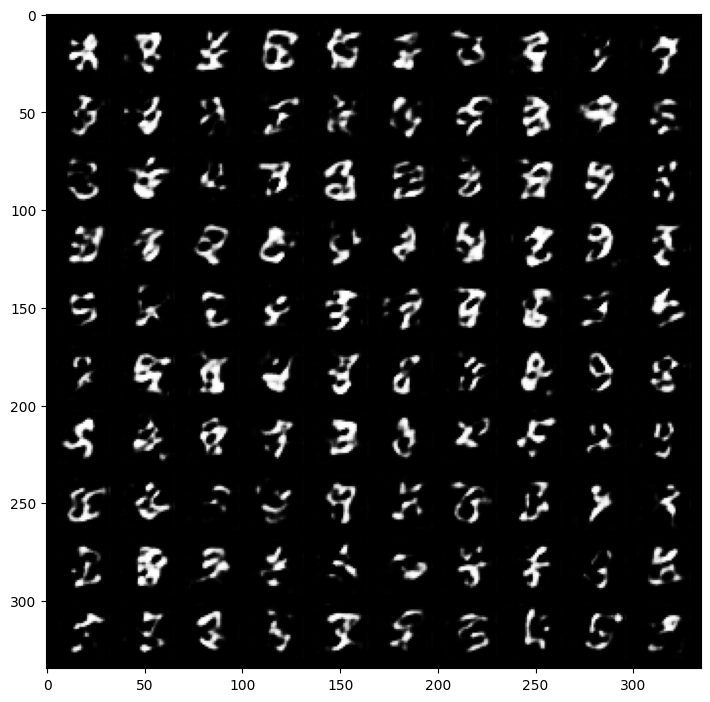

In [11]:
def show_image(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

encoder.eval()
decoder.eval()

with torch.no_grad():
    # calculate mean and std of latent code, generated takining in test images as inputs
    dataiter = iter(test_loader)
    images, small_images = next(dataiter)
    small_images = small_images.to(device)
    latent = encoder(small_images)
    latent = latent.cpu()

    mean = latent.mean(dim=0)
    print(mean)
    std = (latent - mean).pow(2).mean(dim=0).sqrt()
    print(std)

    # sample latent vectors from the normal distribution
    latent = torch.randn(128, d)*std + mean

    # reconstruct images from the random latent vectors
    latent = latent.to(device)
    img_recon = decoder(latent)
    img_recon = img_recon.cpu()

    fig, ax = plt.subplots(figsize=(20, 8.5))
    show_image(torchvision.utils.make_grid(img_recon[:100],10,5))
    plt.show()

In [127]:
from tqdm import tqdm

encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[1].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    encoder.eval()
    with torch.no_grad():
        encoded_img  = encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2056.73it/s]


,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,Enc. Variable 4,Enc. Variable 5,Enc. Variable 6,Enc. Variable 7,Enc. Variable 8,Enc. Variable 9,...,Enc. Variable 55,Enc. Variable 56,Enc. Variable 57,Enc. Variable 58,Enc. Variable 59,Enc. Variable 60,Enc. Variable 61,Enc. Variable 62,Enc. Variable 63,label
0,-0.103982,-0.076670,0.090924,0.084103,0.097793,-0.111462,0.192919,-0.150047,-0.055400,-0.026998,...,0.138711,-0.034872,0.219927,0.130704,0.112779,-0.221847,0.118815,-0.080572,0.084959,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
1,-0.300548,0.189705,-0.109290,-0.036732,-0.022761,-0.013169,0.041483,0.021415,-0.129538,0.167601,...,0.008071,0.293772,-0.071787,0.011273,0.210063,0.026195,0.153470,0.139646,-0.080058,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
2,-0.078625,-0.144482,-0.092244,-0.038552,0.034925,-0.074379,-0.136935,-0.138183,-0.037527,-0.142015,...,0.087918,-0.046045,0.095198,-0.025872,0.166851,-0.024745,0.020868,0.020103,-0.039936,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
3,-0.089900,-0.042633,0.057844,-0.048209,-0.042962,-0.014527,0.296565,-0.052837,0.008793,-0.101465,...,0.015282,-0.010044,0.013392,-0.066916,-0.084016,-0.113061,-0.020364,0.049633,-0.260880,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
4,-0.129866,-0.083424,0.123418,0.247851,0.051366,0.028479,0.105549,0.051734,-0.000729,0.038147,...,0.124616,0.146215,0.017824,0.114215,-0.053545,0.007266,0.074920,0.073808,-0.042982,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,-0.291475,0.166420,0.130244,-0.117623,-0.069313,-0.056112,0.094834,0.062500,0.020774,-0.096898,...,-0.066842,0.206509,0.090203,-0.022675,0.182420,-0.206808,0.016719,0.114936,0.013922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9996,-0.056297,0.034699,-0.009103,-0.233957,0.035677,0.109376,0.208291,0.008764,0.046884,-0.010764,...,0.026404,0.117163,0.226924,-0.093301,0.094352,-0.186716,0.028551,0.265070,-0.226480,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9997,0.024798,0.071945,0.041372,-0.079860,0.024982,-0.139098,-0.183830,-0.202014,0.094602,-0.003065,...,-0.077398,-0.033008,0.058402,0.120732,-0.207095,-0.017642,0.085276,-0.113175,0.016925,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."
9998,-0.114435,0.032509,-0.189186,0.133144,-0.006487,0.017952,0.105430,-0.311832,-0.058925,0.047087,...,-0.005069,0.001952,0.142858,0.068197,-0.062490,-0.241479,-0.044486,-0.062369,0.138922,"[[[tensor(0.), tensor(0.), tensor(0.), tensor(..."


In [ ]:
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1',
           color=encoded_samples.label.astype(str), opacity=0.7)

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
fig = px.scatter(tsne_results, x=0, y=1,
                 color=encoded_samples.label.astype(str),
                 labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()